In [2]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

### Run on GPU if available

In [3]:
if torch.backends.mps.is_available():
    print("The code will run on MPS.")
    device = torch.device('mps')
elif torch.cuda.is_available():
    print("The code will run on GPU.")
    device = torch.device('cuda')
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
    device = torch.device('cpu')

The code will run on MPS.


### Configuration

In [28]:
_optimizer = "Adam"  # "Adam", "SGD", "SGD Momentum"
_lr = 1e-4
_use_batchnorm = True

### Dataset, Model, and Training

Epoch 1/20:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.5265, Train Accuracy: 79.29%, Validation Accuracy: 69.51%


Epoch 2/20:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [2/20], Loss: 0.3630, Train Accuracy: 82.53%, Validation Accuracy: 74.15%


Epoch 3/20:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [3/20], Loss: 0.2821, Train Accuracy: 90.96%, Validation Accuracy: 74.88%


Epoch 4/20:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [4/20], Loss: 0.2294, Train Accuracy: 99.08%, Validation Accuracy: 78.29%


Epoch 5/20:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [5/20], Loss: 0.1853, Train Accuracy: 99.69%, Validation Accuracy: 79.02%


Epoch 6/20:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [6/20], Loss: 0.1590, Train Accuracy: 99.94%, Validation Accuracy: 78.54%


Epoch 7/20:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [7/20], Loss: 0.1321, Train Accuracy: 99.94%, Validation Accuracy: 79.51%


Epoch 8/20:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [8/20], Loss: 0.1130, Train Accuracy: 100.00%, Validation Accuracy: 78.78%


Epoch 9/20:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [9/20], Loss: 0.1003, Train Accuracy: 100.00%, Validation Accuracy: 80.24%


Epoch 10/20:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [10/20], Loss: 0.0888, Train Accuracy: 100.00%, Validation Accuracy: 80.00%


Epoch 11/20:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [11/20], Loss: 0.0824, Train Accuracy: 100.00%, Validation Accuracy: 79.76%


Epoch 12/20:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [12/20], Loss: 0.0739, Train Accuracy: 100.00%, Validation Accuracy: 78.78%


Epoch 13/20:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [13/20], Loss: 0.0674, Train Accuracy: 100.00%, Validation Accuracy: 79.76%


Epoch 14/20:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [14/20], Loss: 0.0637, Train Accuracy: 100.00%, Validation Accuracy: 79.76%


Epoch 15/20:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [15/20], Loss: 0.0582, Train Accuracy: 100.00%, Validation Accuracy: 79.02%


Epoch 16/20:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [16/20], Loss: 0.0545, Train Accuracy: 100.00%, Validation Accuracy: 78.29%


Epoch 17/20:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [17/20], Loss: 0.0496, Train Accuracy: 100.00%, Validation Accuracy: 77.80%


Epoch 18/20:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [18/20], Loss: 0.0473, Train Accuracy: 100.00%, Validation Accuracy: 78.78%


Epoch 19/20:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [19/20], Loss: 0.0435, Train Accuracy: 100.00%, Validation Accuracy: 79.27%


Epoch 20/20:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch [20/20], Loss: 0.0444, Train Accuracy: 100.00%, Validation Accuracy: 78.54%
Test Accuracy: 75.35%
Config: optimizer=Adam, lr=0.0001, batchnorm=True


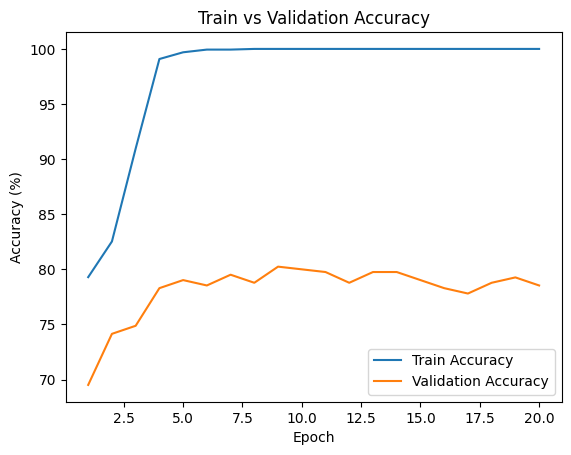

In [29]:
# Define the Hotdog_NotHotdog dataset class
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='hotdog_nothotdog/'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path + '/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

# Define the SimpleCNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) if _use_batchnorm else None
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) if _use_batchnorm else None
        
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64) if _use_batchnorm else None
        
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 64)
        self.bn_fc1 = nn.BatchNorm1d(64) if _use_batchnorm else None
        
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        if _use_batchnorm:
            x = self.bn1(x)
        x = self.pool(F.relu(x))
        
        x = self.conv2(x)
        if _use_batchnorm:
            x = self.bn2(x)
        x = self.pool(F.relu(x))
        
        x = self.conv3(x)
        if _use_batchnorm:
            x = self.bn3(x)
        x = self.pool(F.relu(x))
        
        x = x.view(-1, 64 * 16 * 16)
        x = self.fc1(x)
        if _use_batchnorm:
            x = self.bn_fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        return torch.sigmoid(x)

# Set parameters
size = 128
batch_size = 64
train_transform = transforms.Compose([transforms.Resize((size, size)), transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), transforms.ToTensor()])

# Load the train dataset and split it into training and validation sets
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

# Initialize the model, loss function, and optimizer
model = SimpleCNN().to(device)
criterion = nn.BCELoss()
if _optimizer == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=_lr)
elif _optimizer == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=_lr)
elif _optimizer == "SGD Momentum":
    optimizer = optim.SGD(model.parameters(), lr=_lr, momentum=0.9)

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = (outputs > 0.5).float().squeeze() 
            total += labels.size(0)
            correct += (predicted == labels.float()).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Training loop
num_epochs = 20
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for i, data in enumerate(progress_bar):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() 

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track the loss
        running_loss += loss.item()
        progress_bar.set_postfix({'Loss': running_loss / (i+1)})

    # Calculate train and validation accuracy
    train_acc = calculate_accuracy(train_loader, model)
    val_acc = calculate_accuracy(val_loader, model)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, '
          f'Train Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%')

# Evaluate the model on the test set
test_accuracy = calculate_accuracy(test_loader, model)
print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Config: optimizer={_optimizer}, lr={_lr}, batchnorm={_use_batchnorm}')

# Plot train and validation accuracy
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Train vs Validation Accuracy')
plt.show()

label: hotdog


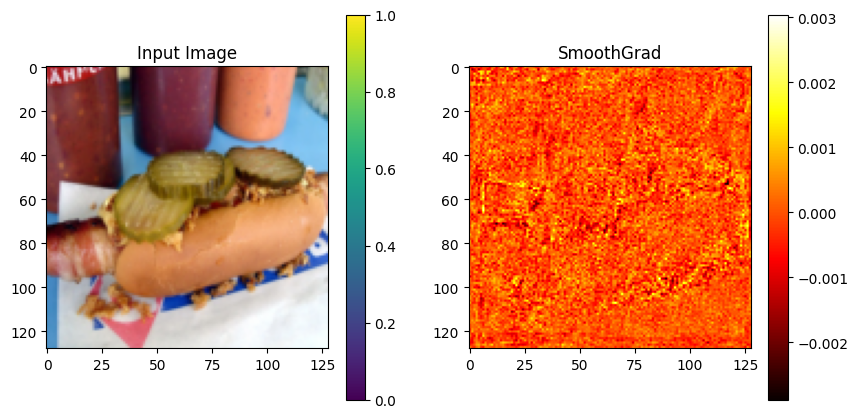

In [98]:
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=0)


def smoothgrad(model, input_tensor, target_class, stdev_spread=0.15, num_samples=500):
    """
    Compute SmoothGrad for a binary classification model (output shape [1, 1]).
    
    Args:
        model: The trained PyTorch model.
        input_tensor: The input for which SmoothGrad is computed (e.g., an image tensor).
        target_class: The target class index (0 or 1 for binary classification).
        stdev_spread: The standard deviation of the noise to be added.
        num_samples: Number of noisy samples to generate.
        
    Returns:
        Averaged gradient with respect to the input.
    """
    
    model.eval()  # Set the model to evaluation mode
    
    # Move input and model to the correct device
    input_tensor = input_tensor.to(device)
    model = model.to(device)
    
    # Get the standard deviation for the noise
    stdev = stdev_spread * (input_tensor.max() - input_tensor.min()).item()
    
    # Initialize smooth_grad variable to accumulate gradients
    smooth_grad = torch.zeros_like(input_tensor)
    
    # Loop through the noisy samples
    for i in range(num_samples):
        # Add Gaussian noise to the input
        noise = torch.normal(mean=0.0, std=stdev, size=input_tensor.size(), device=input_tensor.device)
        noisy_input = input_tensor + noise
        
        # Make sure the noisy input requires gradients
        noisy_input.requires_grad = True
        
        # Zero the gradients before the forward pass
        model.zero_grad()
        
        # Forward pass (add a batch dimension if necessary)
        output = model(noisy_input.unsqueeze(0))  # Model output shape should be [1, 1]
        
        # Handle the target class
        if target_class == 1:
            target_score = output  # If the target class is 1, use the output directly
        else:
            target_score = -output  # If the target class is 0, negate the output
        
        # Backward pass (compute gradients with respect to the target class)
        target_score.backward()
        
        # Accumulate gradients from noisy input
        if noisy_input.grad is not None:
            smooth_grad += noisy_input.grad
        
        # No need to zero gradients manually here
    
    # Average the accumulated gradients
    smooth_grad /= num_samples
    
    return smooth_grad

# Example usage with your data
first_batch = next(iter(test_loader))
second_batch = next(iter(test_loader))
sample, label = second_batch[0][20], second_batch[1][20]

str_label = 'hotdog' if label.item() == 0 else 'not hotdog'
print('label:', str_label)

# Call smoothgrad function
smooth_grad_output = smoothgrad(model=model, 
                                input_tensor=sample, 
                                target_class=label.item(),  # Ensure target_class is an integer (0 or 1)
                                num_samples=50)

# Visualize the input image
input_image = sample.permute(1, 2, 0).detach().cpu().numpy()  # Transpose to (128, 128, 3)

# Convert the smooth_grad_output to a 2D array by averaging across the color channels
smooth_grad_image = smooth_grad_output.mean(dim=0).detach().cpu().numpy()  # Shape (128, 128)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title('Input Image')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(smooth_grad_image, cmap='hot')
plt.title('SmoothGrad')
plt.colorbar()

plt.show()
